<a href="https://colab.research.google.com/github/VinithaJ88/Coursera_Capstone/blob/main/LondonIBMCapstoneFourSquareAPI2021_01_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install required libraries

!pip install geopy
!pip install geocoder
!pip install folium

import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import geocoder
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
from sklearn.metrics import silhouette_score

%matplotlib notebook

print('All libraries imported.')

     |████████████████████████████████| 102kB 4.1MB/s 
All libraries imported.


# Problem Statement: Gourmet Grocery Store in London

We are looking to establish a chain of Gourmet Grocery Stores in London with a range of affordable, sustainably sourced ingredients, and premade sauces. London, the capital of the United Kingdom, is one of the most diverse cities in the world, and is known as the world capital of food. 

We want to identify neigborhoods where consumers frequent Grocery Stores, but also have a marked preference in Asian, African and Middle Eastern cuisines because we have a comparative advantage in sourcing these ingredients. 

#Data Collection

Wikipedia: The neighborhoods in London are scraped from the Wikipedia page: https://en.wikipedia.org/wiki/List_of_areas_of_London. 

Foursquare API: The foursquare API provides us with the venues in every location which we then use to identify the top 10 most popular venues to profile the neighborhoods to identify if the consumer base we are looking for is likely to frequent the neighborhood. We are specifically interested in neighborhoods where consumers frequent grocery stores, and where they also frequent Ethiopian, Thai, Indian restaurants etc. 

Geocoder: We used the geocoder and Geopy to identify the location coordinates for the different neighborhoods in London. 



# Download London neighborhood data into the notebook

In [3]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_areas_of_London', header=0)[1]
df.head(10)



,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728
5,Aldborough Hatch,Redbridge[9],ILFORD,IG2,020,TQ455895
6,Aldgate,City[10],LONDON,EC3,020,TQ334813
7,Aldwych,Westminster[10],LONDON,WC2,020,TQ307810
8,Alperton,Brent[11],WEMBLEY,HA0,020,TQ185835
9,Anerley,Bromley[11],LONDON,SE20,020,TQ345695


In [4]:
df.rename(columns={'Location': 'Neighborhood'}, inplace=True)
df.head()

,Neighborhood,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [5]:
df['Neighborhood'].value_counts()

Plaistow              2
Grove Park            2
Belmont               2
Hayes                 2
Coombe                2
                     ..
Kingston Vale         1
Harrow on the Hill    1
Uxbridge              1
Catford               1
St Luke's             1
Name: Neighborhood, Length: 525, dtype: int64

The next task is to obtain coordinates for each neighborhood in London using Geocoder

In [6]:

df['Latitude1'] = None
df['Longitude1'] = None

for i, neigh in enumerate(df['Neighborhood']):
    lat_lng_coords = None
    
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London'.format(neigh))
        lat_lng_coords = g.latlng
    
    if lat_lng_coords:
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
    
    df.loc[i, 'Latitude1'] = latitude
    df.loc[i, 'Longitude1'] = longitude

df.head(10)

,Neighborhood,London borough,Post town,Postcode district,Dial code,OS grid ref,Latitude1,Longitude1
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785,51.4925,0.12127
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805,51.5132,-0.26746
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645,51.5007,-0.115854
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665,51.4727,-0.203326
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728,51.4858,-0.08026
5,Aldborough Hatch,Redbridge[9],ILFORD,IG2,020,TQ455895,51.4425,-0.201262
6,Aldgate,City[10],LONDON,EC3,020,TQ334813,51.5133,-0.0777647
7,Aldwych,Westminster[10],LONDON,WC2,020,TQ307810,51.5133,-0.11709
8,Alperton,Brent[11],WEMBLEY,HA0,020,TQ185835,51.5269,-0.20644
9,Anerley,Bromley[11],LONDON,SE20,020,TQ345695,51.4123,-0.06539


In [7]:
address = 'London'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of London are {}, {}.'.format(latitude, longitude))

/usr/local/lib/python3.6/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinates of London are 51.5073219, -0.1276474.


The next task: we visualize each of the neighborhoods in London using Folium 

In [8]:
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, neighborhood in zip(df['Latitude1'], df['Longitude1'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

In [9]:
neighborhood_name = df.loc[0, 'Neighborhood']
neighborhood_lat = df.loc[0, 'Latitude1']
neighborhood_long = df.loc[0, 'Longitude1']

print("The neighborhood is {} and it's geographical coordinates are {} latitude and {} longitude".format(neighborhood_name,
                                                                                                        neighborhood_lat, neighborhood_long))

The neighborhood is Abbey Wood and it's geographical coordinates are 51.492450000000076 latitude and 0.12127000000003818 longitude


We use the Foursquare API to extract 10 venues for each of the neighborhoods

In [10]:
#@title
CLIENT_ID = 'RBH5ZTIXC112EFTWHTUBHZ0L3ONZSFHGFSVR4MNLW531JQ02' 
CLIENT_SECRET = '5IXO0QP1WWAH2JTBHPR02YYM4VGIAPPR22XOGHXZ2GQSXRO5'
          
VERSION='20180604'


In [11]:
LIMIT = 100
radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_lat, 
    neighborhood_long, 
    radius, 
    LIMIT)

In [12]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '600a7fb32dd20635beeb3a9d'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4c51917b9d642d7ffacdc3dd-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/historicsite_',
          'suffix': '.png'},
         'id': '4deefb944765f83613cdba6e',
         'name': 'Historic Site',
         'pluralName': 'Historic Sites',
         'primary': True,
         'shortName': 'Historic Site'}],
       'id': '4c51917b9d642d7ffacdc3dd',
       'location': {'address': 'Abbey Rd',
        'cc': 'GB',
        'city': 'Abbey Wood',
        'country': 'United Kingdom',
        'distance': 454,
        'formattedAddress': ['Abbey Rd',
         'Abbey Wood',
         'Greater London',
         'DA17 5DL',
         'United Kingdom'],
        'l

In [13]:
#the function get_categorty_type is defined to obtain category types from the JSON data extracted from the Foursquare APO
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [14]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Lesnes Abbey,Historic Site,51.489526,0.125839
1,Sainsbury's,Supermarket,51.492826,0.120524
2,Lidl,Supermarket,51.496152,0.118417
3,Abbey Wood Railway Station (ABW),Train Station,51.490825,0.123432
4,Costcutter,Convenience Store,51.491287,0.120938


In [15]:
print("{} venues were returned for {} by Foursquare".format(len(nearby_venues), neighborhood_name))

6 venues were returned for Abbey Wood by Foursquare


In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
london_venues = getNearbyVenues(names=df['Neighborhood'], latitudes=df['Latitude1'], longitudes=df['Longitude1'], radius=radius)

Abbey Wood
Acton
Addington
Addiscombe
Albany Park
Aldborough Hatch
Aldgate
Aldwych
Alperton
Anerley
Angel
Aperfield
Archway
Ardleigh Green
Arkley
Arnos Grove
Balham
Bankside
Barbican
Barking
Barkingside
Barnehurst
Barnes
Barnes Cray
Barnet Gate
Barnet (also Chipping Barnet, High Barnet)
Barnsbury
Battersea
Bayswater
Beckenham
Beckton
Becontree
Becontree Heath
Beddington
Bedford Park
Belgravia
Bellingham
Belmont
Belmont
Belsize Park
Belvedere
Bermondsey
Berrylands
Bethnal Green
Bexley (also Old Bexley, Bexley Village)
Bexleyheath (also Bexley New Town)
Bickley
Biggin Hill
Blackfen
Blackfriars
Blackheath
Blackheath Royal Standard
Blackwall
Blendon
Bloomsbury
Botany Bay
Bounds Green
Bow
Bowes Park
Brentford
Brent Cross
Brent Park
Brimsdown
Brixton
Brockley
Bromley
Bromley (also Bromley-by-Bow)
Bromley Common
Brompton
Brondesbury
Brunswick Park
Bulls Cross
Burnt Oak
Burroughs, The
Camberwell
Cambridge Heath
Camden Town
Canary Wharf
Cann Hall
Canning Town
Canonbury
Carshalton
Castelnau
Cast

In [18]:
print(london_venues.shape)
london_venues.head(10)

(14298, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey Wood,51.49245,0.12127,Lesnes Abbey,51.489526,0.125839,Historic Site
1,Abbey Wood,51.49245,0.12127,Sainsbury's,51.492826,0.120524,Supermarket
2,Abbey Wood,51.49245,0.12127,Lidl,51.496152,0.118417,Supermarket
3,Abbey Wood,51.49245,0.12127,Abbey Wood Railway Station (ABW),51.490825,0.123432,Train Station
4,Abbey Wood,51.49245,0.12127,Costcutter,51.491287,0.120938,Convenience Store
5,Abbey Wood,51.49245,0.12127,Platform 1,51.491023,0.119491,Platform
6,Acton,51.51324,-0.26746,Sainsbury's Local,51.514967,-0.268977,Grocery Store
7,Acton,51.51324,-0.26746,Acton Main Line Railway Station (AML),51.517077,-0.267317,Train Station
8,Acton,51.51324,-0.26746,Co-op Food,51.515919,-0.268030,Grocery Store
9,Acton,51.51324,-0.26746,The Balti House,51.516627,-0.267307,Indian Restaurant


In [19]:

print("There are {} unique categories".format(london_venues['Venue Category'].nunique()))

There are 410 unique categories


# Applying one-hot encoder technique to the venue category

In [20]:
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")
london_onehot.head()

,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bathing Area,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,...,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tram Station,Tree,Tunnel,Turkish Restaurant,Udon Restaurant,University,Used Bookstore,Vape Store,Vegetarian / Vegan Restaurant,Veneto Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Warehouse Store,Watch Shop,Whisky Bar,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
london_onehot['Neighborhood'] = london_venues['Neighborhood']
london_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bathing Area,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,...,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tram Station,Tree,Tunnel,Turkish Restaurant,Udon Restaurant,University,Used Bookstore,Vape Store,Vegetarian / Vegan Restaurant,Veneto Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Warehouse Store,Watch Shop,Whisky Bar,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
temp = list(london_onehot.columns)

if 'Neighborhood' in temp:
    temp.remove('Neighborhood')
    
fixed_columns = ['Neighborhood'] + temp
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bathing Area,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,...,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tram Station,Tree,Tunnel,Turkish Restaurant,Udon Restaurant,University,Used Bookstore,Vape Store,Vegetarian / Vegan Restaurant,Veneto Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Warehouse Store,Watch Shop,Whisky Bar,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
london_grouped = london_onehot.groupby('Neighborhood', sort=False).mean().reset_index()
print(london_grouped.shape)
london_grouped.head(10)

(503, 410)


,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bathing Area,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,...,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tram Station,Tree,Tunnel,Turkish Restaurant,Udon Restaurant,University,Used Bookstore,Vape Store,Vegetarian / Vegan Restaurant,Veneto Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Warehouse Store,Watch Shop,Whisky Bar,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Abbey Wood,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,Acton,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,Addington,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.013699,0.013699,0.0,0.000000,0.013699,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013699,0.0,0.041096,0.0,0.0,0.0,0.0,0.0,0.013699,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.013699,0.0,0.013699,0.013699,0.027397,0.0,0.0,0.0,0.013699,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.013699,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,Addiscombe,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.033333,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.016667,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.016667,0.016667,0.0,0.0,0.0,0.0,0.033333,0.0,0.0
4,Albany Park,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5,Aldborough Hatch,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028571,0.0,0.028571,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.028571,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.028571,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.028571,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
6,Aldgate,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.027397,0.000000,0.00,0.0,0.0,0.013699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013699,0.0,0.013699,0.0,0.0,0.0,0.0,0.0,0.027397,0.0,0.0,0.0,0.0,0.0,...,

In [32]:
#identifying the top five venues for each neighborhood

num_top_venues = 5

for hood in london_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


----Abbey Wood----
               venue  freq
0        Supermarket  0.33
1      Train Station  0.17
2  Convenience Store  0.17
3      Historic Site  0.17
4           Platform  0.17


----Acton----
               venue  freq
0      Grocery Store  0.33
1      Train Station  0.17
2  Indian Restaurant  0.17
3     Breakfast Spot  0.17
4               Park  0.17


----Addington----
            venue  freq
0     Coffee Shop  0.10
1           Hotel  0.10
2            Café  0.05
3             Bar  0.04
4  Sandwich Place  0.04


----Addiscombe----
                venue  freq
0  Italian Restaurant  0.10
1                Café  0.08
2                 Pub  0.07
3              Bakery  0.07
4         Coffee Shop  0.07


----Albany Park----
      venue  freq
0      Café  0.33
1  Building  0.17
2       Pub  0.17
3    Garden  0.17
4       Bar  0.17


----Aldborough Hatch----
                 venue  freq
0          Coffee Shop  0.17
1        Grocery Store  0.17
2                  Pub  0.06
3          Pizz

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,Supermarket,Train Station,Historic Site,Platform,Convenience Store,Food,Farmers Market,Entertainment Service,Escape Room,Ethiopian Restaurant
1,Acton,Grocery Store,Breakfast Spot,Park,Train Station,Indian Restaurant,Food & Drink Shop,Farm,Entertainment Service,Escape Room,Ethiopian Restaurant
2,Addington,Hotel,Coffee Shop,Café,Bar,Sandwich Place,Movie Theater,Theme Park Ride / Attraction,Boat or Ferry,Japanese Restaurant,Grocery Store
3,Addiscombe,Italian Restaurant,Café,Coffee Shop,Pub,Bakery,Grocery Store,Juice Bar,Climbing Gym,Thai Restaurant,Park
4,Albany Park,Café,Bar,Building,Pub,Garden,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Factory
...,...,...,...,...,...,...,...,...,...,...,...
498,Woolwich,Fast Food Restaurant,Coffee Shop,Clothing Store,Supermarket,Pub,Bakery,Grocery Store,Pharmacy,Hotel,Plaza
499,Worcester Park,Coffee Shop,Pub,Seafood Restaurant,Supermarket,Bus Stop,Fast Food Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit
500,Wormwood Scrubs,Soccer Field,Park,Convenience Store,Bus Stop,Track Stadium,Coffee Shop,Zoo Exhibit,Ethiopian Restaurant,Event Space,Exhibit
501,Yeading,Brewery,Pub,Café,Park,Bakery,Coffee Shop,Grocery Store,Platform,Cocktail Bar,Clothing Store


# Applying kmeans clustering to the dataset

In [35]:
#plotting the silouette scores for different k values 
def plot(x, y):
    fig = plt.figure(figsize=(12,6))
    plt.plot(x, y, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Scores')
    plt.title('Checking Optimum Number of Clusters')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [36]:
maxk = 15
scores = []
kval = []

for k in range(2, maxk+1):
    cl_df = london_grouped.drop('Neighborhood', axis=1)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit_predict(cl_df) #Choose any random_state
    
    score = silhouette_score(cl_df, kmeans, metric='euclidean', random_state=0)
    kval.append(k)
    scores.append(score)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


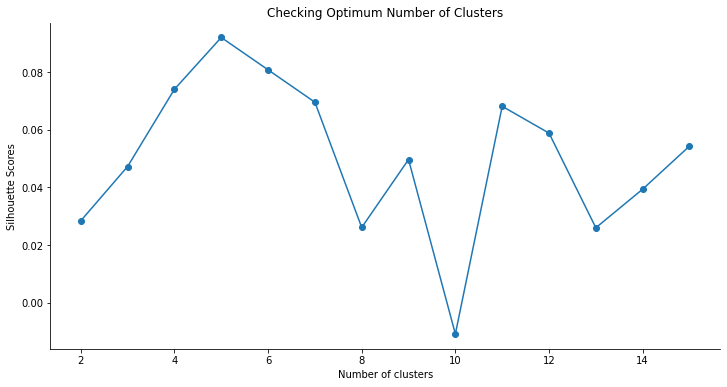

In [37]:
print(kval)
plot(kval, scores)

In [38]:
k = 5

london_clustering = london_grouped.drop('Neighborhood', axis=1)
kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit(london_clustering) #Can choose any random_state

kmeans.labels_

array([3, 4, 3, 3, 1, 4, 3, 3, 4, 1, 3, 3, 3, 1, 4, 1, 3, 3, 3, 1, 3, 3,
       3, 3, 1, 3, 3, 3, 3, 4, 4, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,
       3, 3, 4, 3, 3, 1, 4, 3, 1, 3, 3, 1, 1, 1, 3, 3, 3, 4, 3, 3, 3, 3,
       3, 3, 0, 1, 3, 3, 3, 2, 3, 3, 3, 1, 1, 3, 4, 1, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 4, 4, 3, 4, 1, 3, 0, 3, 4, 3, 3,
       3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 1,
       3, 3, 3, 3, 1, 3, 4, 3, 4, 3, 4, 4, 3, 3, 3, 4, 1, 3, 3, 3, 1, 3,
       3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 4, 3, 3,
       1, 3, 3, 3, 3, 3, 1, 4, 1, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3,
       3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3,
       1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 4, 4, 3, 4, 3, 3, 3, 1, 1, 3, 4,
       1, 1, 3, 3, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 1, 3, 3, 4, 3, 3, 3, 4,
       3, 3, 1, 1, 3, 3, 3, 3, 4, 1, 3, 3, 1, 3, 3, 4, 4, 1, 3, 3, 4, 3,
       4, 1, 3, 3, 3, 2, 0, 3, 3, 3, 1, 3, 3, 4, 3,

In [39]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
london_merged = df
london_merged = london_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [40]:
print(london_merged.shape)
london_merged

(531, 19)


,Neighborhood,London borough,Post town,Postcode district,Dial code,OS grid ref,Latitude1,Longitude1,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785,51.4925,0.12127,3.0,Supermarket,Train Station,Historic Site,Platform,Convenience Store,Food,Farmers Market,Entertainment Service,Escape Room,Ethiopian Restaurant
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805,51.5132,-0.26746,4.0,Grocery Store,Breakfast Spot,Park,Train Station,Indian Restaurant,Food & Drink Shop,Farm,Entertainment Service,Escape Room,Ethiopian Restaurant
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645,51.5007,-0.115854,3.0,Hotel,Coffee Shop,Café,Bar,Sandwich Place,Movie Theater,Theme Park Ride / Attraction,Boat or Ferry,Japanese Restaurant,Grocery Store
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665,51.4727,-0.203326,3.0,Italian Restaurant,Café,Coffee Shop,Pub,Bakery,Grocery Store,Juice Bar,Climbing Gym,Thai Restaurant,Park
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728,51.4858,-0.08026,1.0,Café,Bar,Building,Pub,Garden,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Factory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,Woolwich,Greenwich,LONDON,SE18,020,TQ435795,51.4895,0.06538,3.0,Fast Food Restaurant,Coffee Shop,Clothing Store,Supermarket,Pub,Bakery,Grocery Store,Pharmacy,Hotel,Plaza
527,Worcester Park,"Sutton, Kingston upon Thames",WORCESTER PARK,KT4,020,TQ225655,51.371,-0.228085,1.0,Coffee Shop,Pub,Seafood Restaurant,Supermarket,Bus Stop,Fast Food Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit
528,Wormwood Scrubs,Hammersmith and Fulham,LONDON,W12,020,TQ225815,51.5184,-0.23713,3.0,Soccer Field,Park,Convenience Store,Bus Stop,Track Stadium,Coffee Shop,Zoo Exhibit,Ethiopian Restaurant,Event Space,Exhibit
529,Yeading,Hillingdon,HAYES,UB4,020,TQ115825,51.5446,-0.0575111,3.0,Brewery,Pub,Café,Park,Bakery,Coffee Shop,Grocery Store,Platform,Cocktail Bar,Clothing Store


# Visualising different clusters on the map of London

In [42]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude1'], london_merged['Longitude1'], london_merged['Neighborhood'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=['yellow', 'green', 'red', 'blue', 'black'],
        fill=True,
        fill_color=['#3186cc'],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [43]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[0] + [1] + list(range(5, london_merged.shape[1]))]]

,Neighborhood,London borough,OS grid ref,Latitude1,Longitude1,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
70,Brunswick Park,Barnet[37],TQ280932,51.5836,-0.07607,0.0,Coffee Shop,Pub,Grocery Store,Café,Train Station,South American Restaurant,Hardware Store,Tapas Restaurant,Entertainment Service,Escape Room
113,Coulsdon,Croydon,TQ298596,51.2876,-0.155303,0.0,Coffee Shop,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm
169,Feltham,Hounslow,TQ105735,51.4484,-0.448491,0.0,Café,IT Services,Restaurant,Coffee Shop,Zoo Exhibit,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop
311,Monken Hadley,Barnet,TQ245975,51.6132,-0.18747,0.0,Café,Grocery Store,Chinese Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Factory
345,Oakleigh Park,Barnet,TQ265935,51.6373,-0.16638,0.0,Café,Zoo Exhibit,Field,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm
346,Old Coulsdon,Croydon,TQ315575,51.2876,-0.155303,0.0,Coffee Shop,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm
396,Seven Sisters,Haringey,TQ334888,51.5819,-0.07493,0.0,Coffee Shop,Grocery Store,Pub,Hardware Store,Train Station,Pizza Place,Tapas Restaurant,Café,South American Restaurant,Factory


# Cluster 1: Most Common Venues are often Cafes

In [44]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[0] + [1] + list(range(5, london_merged.shape[1]))]]

,Neighborhood,London borough,OS grid ref,Latitude1,Longitude1,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Albany Park,Bexley,TQ478728,51.4858,-0.08026,1.0,Café,Bar,Building,Pub,Garden,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Factory
9,Anerley,Bromley[11],TQ345695,51.4123,-0.06539,1.0,Train Station,Pub,Park,Hardware Store,Grocery Store,Gas Station,Farm,Entertainment Service,Escape Room,Ethiopian Restaurant
13,Ardleigh Green,Havering[12],TQ535895,51.5448,-0.0831226,1.0,Pub,Bus Stop,Grocery Store,Thai Restaurant,Convenience Store,Gastropub,Café,Cocktail Bar,Bagel Shop,Caribbean Restaurant
15,Arnos Grove,Enfield[12],TQ295925,51.6224,-0.127232,1.0,Café,Cricket Ground,Pub,Mediterranean Restaurant,Hotel,Fish & Chips Shop,Zoo Exhibit,Ethiopian Restaurant,Event Space,Exhibit
19,Barking,Barking and Dagenham[14],TQ440840,51.5338,0.0626097,1.0,Pub,Gym Pool,Chinese Restaurant,Sandwich Place,Zoo Exhibit,Farm,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Space
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,West Drayton,Hillingdon,TQ065795,51.5951,-0.01187,1.0,Gym / Fitness Center,Pub,Concert Hall,Pool,Café,Zoo Exhibit,Farmers Market,Escape Room,Ethiopian Restaurant,Event Space
502,West Ham,Newham,TQ405837,51.5301,0.0209501,1.0,Platform,Park,Pub,Fried Chicken Joint,Bus Stop,Boutique,Metro Station,Zoo Exhibit,Fast Food Restaurant,Event Space
508,West Norwood,Lambeth,TQ325715,51.4341,-0.10375,1.0,Pub,Grocery Store,Bakery,Recreation Center,Pharmacy,Coffee Shop,Sandwich Place,Train Station,Farmers Market,Café
515,Widmore (also Widmore Green),Bromley,TQ411691,51.5613,-0.126888,1.0,Pub,Grocery Store,Gym / Fitness Center,Pizza Place,Bar,Kebab Restaurant,Mediterranean Restaurant,Thai Restaurant,Eastern European Restaurant,Coffee Shop


# Cluster 2: Construction & Landscaping Venues

In [45]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[0] + [1] + list(range(5, london_merged.shape[1]))]]

,Neighborhood,London borough,OS grid ref,Latitude1,Longitude1,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
76,Camden Town,Camden[40],TQ295845,43.0248,-81.2677,2.0,Construction & Landscaping,Zoo Exhibit,Field,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant
310,Mitcham,Merton,TQ285685,51.3877,-0.158222,2.0,Construction & Landscaping,Zoo Exhibit,Field,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant
422,Southborough,Bromley,TQ423676,38.7949,-104.751,2.0,Construction & Landscaping,Wine Bar,Zoo Exhibit,Field,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Factory


# Cluster 3 Pubs and Cocktail Bars

In [46]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0] + [1] + list(range(5, london_merged.shape[1]))]]

,Neighborhood,London borough,OS grid ref,Latitude1,Longitude1,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,"Bexley, Greenwich [7]",TQ465785,51.4925,0.12127,3.0,Supermarket,Train Station,Historic Site,Platform,Convenience Store,Food,Farmers Market,Entertainment Service,Escape Room,Ethiopian Restaurant
2,Addington,Croydon[8],TQ375645,51.5007,-0.115854,3.0,Hotel,Coffee Shop,Café,Bar,Sandwich Place,Movie Theater,Theme Park Ride / Attraction,Boat or Ferry,Japanese Restaurant,Grocery Store
3,Addiscombe,Croydon[8],TQ345665,51.4727,-0.203326,3.0,Italian Restaurant,Café,Coffee Shop,Pub,Bakery,Grocery Store,Juice Bar,Climbing Gym,Thai Restaurant,Park
6,Aldgate,City[10],TQ334813,51.5133,-0.0777647,3.0,Hotel,Cocktail Bar,Coffee Shop,Wine Bar,Restaurant,Gym / Fitness Center,English Restaurant,Pizza Place,Garden,Turkish Restaurant
7,Aldwych,Westminster[10],TQ307810,51.5133,-0.11709,3.0,Pub,Theater,Coffee Shop,Restaurant,Hotel,Burger Joint,French Restaurant,Italian Restaurant,Gelato Shop,Dessert Shop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,Woodside Park,Barnet,TQ256925,51.6227,-0.1915,3.0,Soccer Field,Photography Studio,Bus Stop,Lake,Zoo Exhibit,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop
526,Woolwich,Greenwich,TQ435795,51.4895,0.06538,3.0,Fast Food Restaurant,Coffee Shop,Clothing Store,Supermarket,Pub,Bakery,Grocery Store,Pharmacy,Hotel,Plaza
528,Wormwood Scrubs,Hammersmith and Fulham,TQ225815,51.5184,-0.23713,3.0,Soccer Field,Park,Convenience Store,Bus Stop,Track Stadium,Coffee Shop,Zoo Exhibit,Ethiopian Restaurant,Event Space,Exhibit
529,Yeading,Hillingdon,TQ115825,51.5446,-0.0575111,3.0,Brewery,Pub,Café,Park,Bakery,Coffee Shop,Grocery Store,Platform,Cocktail Bar,Clothing Store



# Cluster 4: Grocery Stores are the most common venue

In [47]:
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[0] + [1] + list(range(5, london_merged.shape[1]))]]

,Neighborhood,London borough,OS grid ref,Latitude1,Longitude1,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Acton,"Ealing, Hammersmith and Fulham[8]",TQ205805,51.5132,-0.26746,4.0,Grocery Store,Breakfast Spot,Park,Train Station,Indian Restaurant,Food & Drink Shop,Farm,Entertainment Service,Escape Room,Ethiopian Restaurant
5,Aldborough Hatch,Redbridge[9],TQ455895,51.4425,-0.201262,4.0,Grocery Store,Coffee Shop,Pub,Pizza Place,Sporting Goods Shop,Veterinarian,Fish & Chips Shop,Metro Station,Park,Thai Restaurant
8,Alperton,Brent[11],TQ185835,51.5269,-0.20644,4.0,Grocery Store,Middle Eastern Restaurant,Lebanese Restaurant,French Restaurant,Gym,Bakery,Cocktail Bar,Canal,Garden,Pizza Place
14,Arkley,Barnet[12],TQ225955,51.5798,-0.030331,4.0,Grocery Store,Supermarket,Food & Drink Shop,Warehouse Store,Eastern European Restaurant,Gym / Fitness Center,Pie Shop,Café,Furniture / Home Store,History Museum
29,Beckenham,Bromley[20],TQ375695,51.6225,-0.0790722,4.0,Fast Food Restaurant,Greek Restaurant,Sandwich Place,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Factory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,Wembley,Brent,TQ175855,42.9786,-81.3157,4.0,Fried Chicken Joint,Gas Station,Fast Food Restaurant,Zoo Exhibit,Field,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop
495,Wembley Park,Brent,TQ192863,42.9786,-81.3157,4.0,Fried Chicken Joint,Gas Station,Fast Food Restaurant,Zoo Exhibit,Field,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop
499,West Ealing,Ealing,TQ153802,51.5135,-0.31971,4.0,Indian Restaurant,Grocery Store,Persian Restaurant,Coffee Shop,Pub,Gym / Fitness Center,Sandwich Place,Bagel Shop,Bakery,Bar
506,West Hendon,Barnet,TQ215885,51.5846,-0.216209,4.0,Grocery Store,Pizza Place,Indian Restaurant,Bagel Shop,Park,Middle Eastern Restaurant,Café,Escape Room,Ethiopian Restaurant,Event Space


In [59]:
new_grocerystore_neighborhoods = london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[0, 1, 2, 3] + list(range(5, london_merged.shape[1]))]]
new_grocerystore_neighborhoods.head(50)

,Neighborhood,London borough,Post town,Postcode district,OS grid ref,Latitude1,Longitude1,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",TQ205805,51.5132,-0.26746,4.0,Grocery Store,Breakfast Spot,Park,Train Station,Indian Restaurant,Food & Drink Shop,Farm,Entertainment Service,Escape Room,Ethiopian Restaurant
5,Aldborough Hatch,Redbridge[9],ILFORD,IG2,TQ455895,51.4425,-0.201262,4.0,Grocery Store,Coffee Shop,Pub,Pizza Place,Sporting Goods Shop,Veterinarian,Fish & Chips Shop,Metro Station,Park,Thai Restaurant
8,Alperton,Brent[11],WEMBLEY,HA0,TQ185835,51.5269,-0.20644,4.0,Grocery Store,Middle Eastern Restaurant,Lebanese Restaurant,French Restaurant,Gym,Bakery,Cocktail Bar,Canal,Garden,Pizza Place
14,Arkley,Barnet[12],"BARNET, LONDON","EN5, NW7",TQ225955,51.5798,-0.030331,4.0,Grocery Store,Supermarket,Food & Drink Shop,Warehouse Store,Eastern European Restaurant,Gym / Fitness Center,Pie Shop,Café,Furniture / Home Store,History Museum
29,Beckenham,Bromley[20],"BECKENHAM, LONDON","BR3, SE20",TQ375695,51.6225,-0.0790722,4.0,Fast Food Restaurant,Greek Restaurant,Sandwich Place,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Factory
30,Beckton,Newham[20],"LONDON, BARKING","E6, E16, IG11",TQ435815,51.5329,0.05461,4.0,Fast Food Restaurant,Pub,Coffee Shop,Sporting Goods Shop,Supermarket,Bookstore,Park,Electronics Store,Bakery,Grocery Store
47,Biggin Hill,Bromley[26],WESTERHAM,TN16,TQ418590,51.4147,-0.104515,4.0,Forest,Grocery Store,Mattress Store,Football Stadium,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant
51,Blackheath Royal Standard,Greenwich,LONDON,"SE3, SE12",TQ399753,51.4769,0.01881,4.0,Bakery,Furniture / Home Store,Chinese Restaurant,Fast Food Restaurant,Café,Grocery Store,Pub,Flea Market,Farm,Escape Room
62,Brimsdown,Enfield[34],ENFIELD,EN3,TQ365975,51.6613,-0.030864,4.0,Grocery Store,Furniture / Home Store,Soccer Field,Gym,Farmers Market,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Space,Exhibit
84,Catford,Lewisham,LONDON,SE6,TQ385735,51.4372,-0.01868,4.0,Pizza Place,Furniture / Home Store,Train Station,Shopping Plaza,Turkish Restaurant,Discount Store,Grocery Store,Fish & Chips Shop,Film Studio,Entertainment Service


# Visualising Cluster 4 locations for the Gourmet Grocery Store

In [60]:
map_res_locations = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng,  neighborhood in zip(new_restaurant_neighborhoods['Latitude1'], new_restaurant_neighborhoods['Longitude1'],
                                             new_restaurant_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, location)
    folium.Marker([lat, lng], popup='{} has geographical coordinates ({:.4f}, {:.4f})'.format(label, lat, lng),
                  icon=folium.Icon(color='lightred'), tooltip=label).add_to(map_res_locations)
    
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_res_locations) 

map_res_locations

# Discussion: Where do we open our chain of Gourmet Grocery Stores?

CLuster 0 has Coffee shops as the first venue. It also has Ethiopian restaurant as the fourth most common venue. If the foremost footfall in these areas is in Coffee shops, it is unlikely that a grocery store might witness the amount of footfall required to sustain our chain of Gourmet Grocery Stores. 

Cluster 1 has a number of Pubs and Cafes. Grocery stores are the third most common venues. It has a fair share of Ethiopian/Indian/Turkish cuisine restaurants as the third most common venue etc. It is a fair contender for the cluster in which the Gourmet Grocery stores should be concentrated in, although the most popular venues are Pubs and Cafes. 

Cluster 2 seems to be an area where a lot of construction activity is underway. Hence Cluster 2 might not be the right fit for our chain of Gourmet Grocery Stores.

Cluster 3 has a large number of Pubs, Cocktail bars, Cafes, Breweries etc. It does seem like the type of venues people might frequent when they are looking to socialise - not so much in the state of mind to carry bulky grocery bags around with them (although Clustr 3 also shows a number of farmers markets). Since our Gourmet Grocery Store will be stocking up on well sourced ingredients for Asian, Middle Eastern and African cuisines, it might not cater to the preferences of the customers who frequent Breweries, farmer's markets, pizza places, wine bars and Italian Restaurants. 


Cluster 4 presents a range of venues where the most popular venue is frequently a grocery store - the vicinity also has a number of Furniture/home stores and restaurants like Ethiopian/Indian/Turkish/Dimsum shops amongst others. 

So, it does seem to be the clusters where homemakers might want to catch up on some Weekend shopping for some gourmet ingredients. If the gourmet store can be stocked with ingredients for homecooks to whip up some Ethiopian/Turkish/Lebanese/Indian foods, it might actually do quite well judging by the popularity of such cuisines in those vicinities. 

#Conclusion


We have completed our analysis and we recommend the venues in Cluster 4 for the opening of the Gourmet Grocery store chain. The store if it contains a range of cost-effective, and sustainably sourced ingredients, prepared sauces, breads and spices from Ethiopian, Indian, Turkish cuisines, it might be quite profitable given the footfall in neighboring grocery stores. 